In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
transform = transforms.Compose([transforms.ToTensor()])


In [3]:
# Load train, validation and test dataset
data_dir = os.getcwd()
print("data_dir", data_dir)
train_file = os.path.join(data_dir, "train")
print("train_file", train_file)
val_file = os.path.join(data_dir, "validation")
print("val_file", val_file)
test_file = os.path.join(data_dir, "test")
print("test_file", test_file)


data_dir C:\Users\etson\PycharmProjects\pythonProject
train_file C:\Users\etson\PycharmProjects\pythonProject\train
val_file C:\Users\etson\PycharmProjects\pythonProject\validation
test_file C:\Users\etson\PycharmProjects\pythonProject\test


In [4]:
train_dataset = datasets.ImageFolder(train_file, transform=transform)
valid_dataset = datasets.ImageFolder(val_file, transform=transform)
test_dataset = datasets.ImageFolder(test_file, transform=transform)


In [5]:
# Handling imbalanced dataset for training
class_counts = torch.tensor([144435, 57089])
class_weights = 1. / class_counts
samples_weights = torch.tensor([class_weights[t] for t in train_dataset.targets])
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))


In [6]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
model = SimpleCNN()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=5):
    train_f1_scores, valid_f1_scores, train_losses, valid_losses = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        preds, true = [], []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.view(-1).cpu().numpy())
            true.extend(labels.view(-1).cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_f1 = f1_score(true, preds, average='binary')
        train_losses.append(epoch_loss)
        train_f1_scores.append(epoch_f1)
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.view(-1).cpu().numpy())
                val_true.extend(labels.view(-1).cpu().numpy())
            
        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_epoch_f1 = f1_score(val_true, val_preds, average='binary')
        valid_losses.append(val_epoch_loss)
        valid_f1_scores.append(val_epoch_f1)
        
        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train F1: {epoch_f1:.4f}, Val Loss: {val_epoch_loss:.4f}, Val F1: {val_epoch_f1:.4f}')
    
    return train_losses, train_f1_scores, valid_losses, valid_f1_scores


In [11]:
# Training the model
train_losses, train_f1_scores, valid_losses, valid_f1_scores = train_model(model, criterion, optimizer, num_epochs=5)


Epoch 1, Train Loss: 0.4203, Train F1: 0.8130, Val Loss: 0.3601, Val F1: 0.7464
Epoch 2, Train Loss: 0.3729, Train F1: 0.8397, Val Loss: 0.4130, Val F1: 0.7405
Epoch 3, Train Loss: 0.3576, Train F1: 0.8475, Val Loss: 0.3443, Val F1: 0.7538
Epoch 4, Train Loss: 0.3471, Train F1: 0.8530, Val Loss: 0.3845, Val F1: 0.7483
Epoch 5, Train Loss: 0.3317, Train F1: 0.8609, Val Loss: 0.3934, Val F1: 0.7487


In [12]:
def evaluate_model(model, data_loader):
    model.eval()
    test_preds, test_true = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.view(-1).cpu().numpy())
            test_true.extend(labels.view(-1).cpu().numpy())
    f1 = f1_score(test_true, test_preds, average='binary')
    # For ROC AUC, we need the probability of the positive class which requires a slight modification to the model or using softmax
    # outputs_prob = torch.softmax(outputs, dim=1)[:, 1] # Assuming model modification
    # roc_auc = roc_auc_score(test_true, outputs_prob.cpu().numpy())
    return f1 #, roc_auc


In [13]:
# Evaluation
test_f1 = evaluate_model(model, test_loader)
print(f'Test F1: {test_f1:.4f}')


Test F1: 0.7479


In [14]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'simple_cnn_model.pth')
print("Model saved successfully after evaluation.")

Model saved successfully after evaluation.


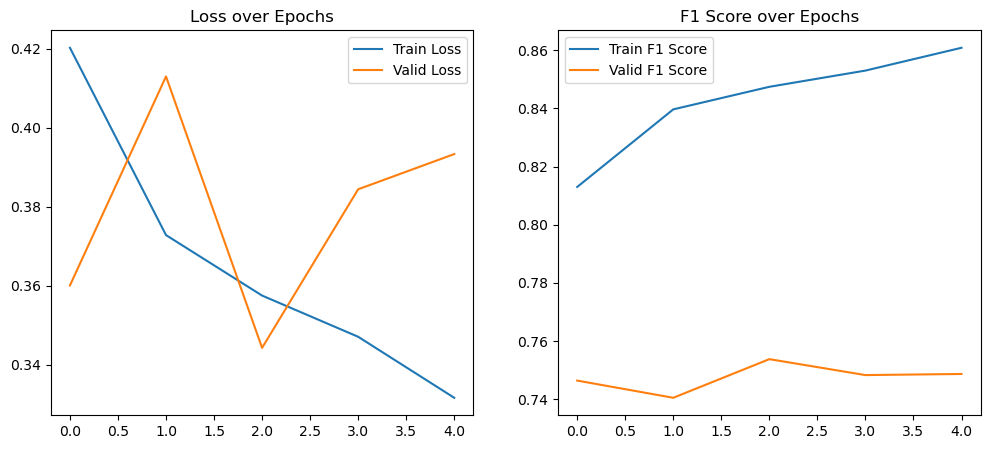

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(valid_f1_scores, label='Valid F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.show()
